# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from collections import OrderedDict

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


## Split into train/test sets

In [4]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Define helper methods

In [5]:
def cv_learn(clf, X_train, y_train, X_test, y_test,
             cv_size=5, scoring_type="accuracy", average_type="macro"):
    # 5xCV
    y_scores = cross_val_score(clf, X_train, y_train,
                               cv=cv_size, scoring=scoring_type)
    # Test Prediction
    pred = cross_val_predict(clf, X_test, y_test, cv=cv_size)

    # Conf. Matrix
    matrix = confusion_matrix(y_test, pred)

    # CLF. Report
    report_str = classification_report(y_test, pred)
    report_dict = classification_report(y_test, pred, output_dict=True)

    return (y_scores, pred, matrix, report_str, report_dict)


def print_cv_scores(scores):
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


def print_conf_matrix(clf_name, matrix):
    print(clf_name, ":\n", matrix)


def plot_confusion_matrix(clf_name, class_names, cm, figsize):
    df_cm = pd.DataFrame(cm, index=[i for i in class_names],
                         columns=[i for i in class_names])
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="jet").set_title(
        "Confusion Matrix for: " + str(clf_name))


def print_learning_results_multiple(classifs, class_names, scores, matrices, reports):
    for item in zip(classifs, scores, matrices, reports):
        print(item[0])
        print(item[1])
        print_cv_scores(item[1])
        print_conf_matrix(item[0], item[2])
        # Plot non-normalized confusion matrix
        plot_confusion_matrix(item[0], class_names, item[2], (10, 7))
        print(item[3])
        print("\n")


def print_learning_results_single(clf, class_names, scores, matrix, report):
    print(clf)
    print(scores)
    print_cv_scores(scores)
    print_conf_matrix(clf, matrix)
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(clf, class_names, matrix, (10, 7))
    print(report)
    print("\n")


class_names = ["GALAXY", "QSO", "STAR"]


class ResultSet:
    def __init__(self, clf_name, scores, predictions, matrix, report_str, report_dict):
        self.classifier_name = clf_name
        self.scores = scores
        self.predictions = predictions
        self.matrix = matrix
        self.report_str = report_str
        self.report_dict = report_dict


def print_kv_arr(ordered_by, arr):
    print(ordered_by)
    for kv in arr:
        print(kv[0], kv[1])
    print("\n")


def roc_auc_score_multiclass(actual_class, pred_class, average="macro"):
    # creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        # creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(
            new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict


def order_results(result_sets):
    by_acc = {}
    by_prec_micro = {}
    by_recall_micro = {}
    by_f1_micro = {}

    by_acc_macro = {}
    by_prec_macro = {}
    by_recall_macro = {}
    by_f1_macro = {}

    for result_set in result_sets:
        by_acc[result_set.classifier_name] = result_set.scores.mean()

        micro_results = result_set.report_dict["micro avg"]
        macro_results = result_set.report_dict["macro avg"]

        by_prec_micro[result_set.classifier_name] = micro_results["precision"]
        by_prec_macro[result_set.classifier_name] = macro_results["precision"]

        by_recall_micro[result_set.classifier_name] = micro_results["recall"]
        by_recall_macro[result_set.classifier_name] = macro_results["recall"]

        by_f1_micro[result_set.classifier_name] = micro_results["f1-score"]
        by_f1_macro[result_set.classifier_name] = macro_results["f1-score"]

    sorted_acc = sorted(by_acc.items(), key=lambda kv: kv[1], reverse=True)

    sorted_prec_micro = sorted(by_prec_micro.items(), key=lambda kv: kv[1], reverse=True)
    sorted_recall_micro = sorted(by_recall_micro.items(), key=lambda kv: kv[1], reverse=True)
    sorted_f1_micro = sorted(by_f1_micro.items(), key=lambda kv: kv[1], reverse=True)

    sorted_prec_macro = sorted(by_prec_macro.items(), key=lambda kv: kv[1], reverse=True)
    sorted_recall_macro = sorted(by_recall_macro.items(), key=lambda kv: kv[1], reverse=True)
    sorted_f1_macro = sorted(by_f1_macro.items(), key=lambda kv: kv[1], reverse=True)

    print_kv_arr("By Acc:", sorted_acc)
    print_kv_arr("By Precision(avg=micro):", sorted_prec_micro)
    print_kv_arr("By Recall(avg=micro):", sorted_recall_micro)
    print_kv_arr("By F1(avg=micro):", sorted_f1_micro)
    print_kv_arr("By Precision(avg=macro):", sorted_prec_macro)
    print_kv_arr("By Recall(avg=macro):", sorted_recall_macro)
    print_kv_arr("By F1(avg=macro):", sorted_f1_macro)


def do_stuff(clf, clf_name, class_names, X_train, y_train, X_test, y_test, result_sets):
    scores, predictions, matrix, report_str, report_dict = cv_learn(
        clf, X_train, y_train, X_test, y_test)

    # append results for later use
    result_sets.append(
        ResultSet(clf_name, scores, predictions, matrix, report_str, report_dict))

    # print results
    print_learning_results_single(
        clf_name, class_names, scores, matrix, report_str)


def print_roc_auc_scores(result_sets, y_true):
    for result_set in result_sets:
        print(result_set.classifier_name)
        # assuming your already have a list of actual_class and predicted_class
        score = roc_auc_score_multiclass(y_true, result_set.predictions)
        print(score)
        print("\n")

## Scale the data

In [6]:
robust_scaler = RobustScaler()

X_train_rob_scaled = robust_scaler.fit_transform(X_train.astype(np.float64))
X_test_rob_scaled = robust_scaler.fit_transform(X_test.astype(np.float64))

# Classification

## Prepare result sets

In [7]:
result_sets = []

## KNN

KNN
[0.96535643 0.9586942  0.96866667 0.96931288 0.96597732]
Accuracy: 0.966 (+/- 0.008)
KNN :
 [[1133    5  108]
 [  17  225    0]
 [  28    0  984]]
              precision    recall  f1-score   support

      GALAXY       0.96      0.91      0.93      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.90      0.97      0.94      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500





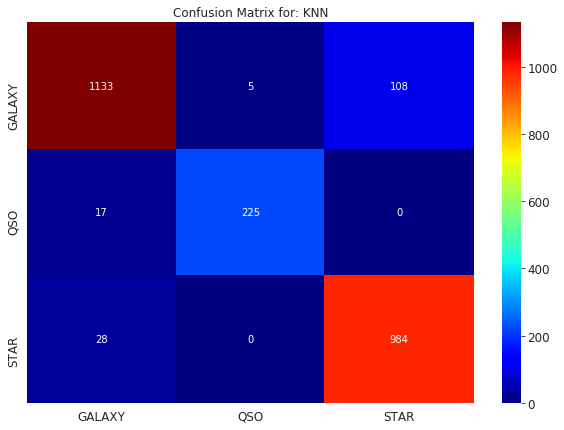

In [8]:
knn_clf = KNeighborsClassifier()
do_stuff(knn_clf, "KNN", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## SVC


SVC
[0.98067955 0.9733511  0.98466667 0.98599066 0.98332221]
Accuracy: 0.982 (+/- 0.009)
SVC :
 [[1198    3   45]
 [  16  226    0]
 [   0    2 1010]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.96      1.00      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.97      0.97      0.97      2500





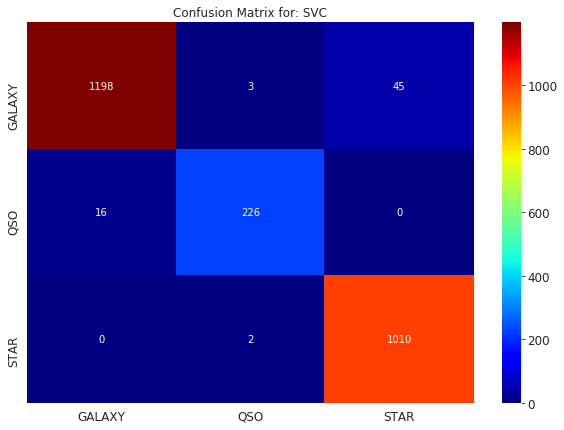

In [9]:
svm_clf = SVC(gamma="auto", random_state=42)
do_stuff(svm_clf, "SVC", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Linear SVM

LinearSVC
[0.96868754 0.96802132 0.98133333 0.97798532 0.97331554]
Accuracy: 0.974 (+/- 0.010)
LinearSVC :
 [[1215    7   24]
 [  27  215    0]
 [  12    1  999]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97      1246
         QSO       0.96      0.89      0.92       242
        STAR       0.98      0.99      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.95      0.96      2500
weighted avg       0.97      0.97      0.97      2500





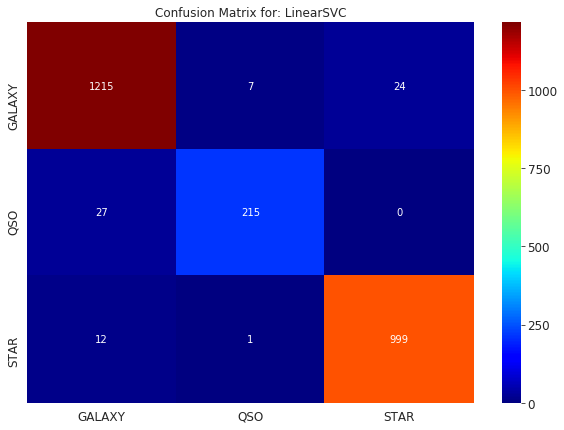

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lsvm_clf = LinearSVC(C=10, loss="hinge", random_state=42)
    do_stuff(lsvm_clf, "LinearSVC", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Nu-SVM

NuSVC
[0.98334444 0.97534977 0.986      0.98932622 0.98665777]
Accuracy: 0.984 (+/- 0.010)
NuSVC :
 [[1222    2   22]
 [  16  226    0]
 [   0    2 1010]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500





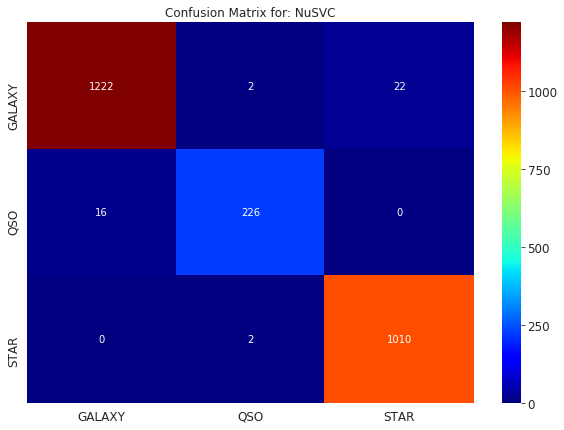

In [11]:
nusvm_clf = NuSVC(nu=0.05, gamma=0.1)
do_stuff(nusvm_clf, "NuSVC", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## RBF Kernel - SVM

RbfKernelSVM
[0.98734177 0.98467688 0.98733333 0.98932622 0.98398933]
Accuracy: 0.987 (+/- 0.004)
RbfKernelSVM :
 [[1223    4   19]
 [  15  227    0]
 [   4    1 1007]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500





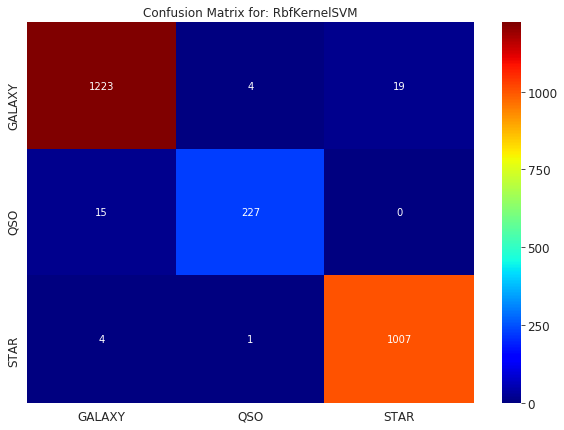

In [12]:
rbf_svm_clf = SVC(kernel="rbf", gamma=0.1, C=1000)
do_stuff(rbf_svm_clf, "RbfKernelSVM", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Poly Kernel SVM

PolyKernelSVM
[0.99200533 0.98934044 0.994      0.99132755 0.98865911]
Accuracy: 0.991 (+/- 0.004)
PolyKernelSVM :
 [[1230    7    9]
 [  12  230    0]
 [   7    0 1005]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





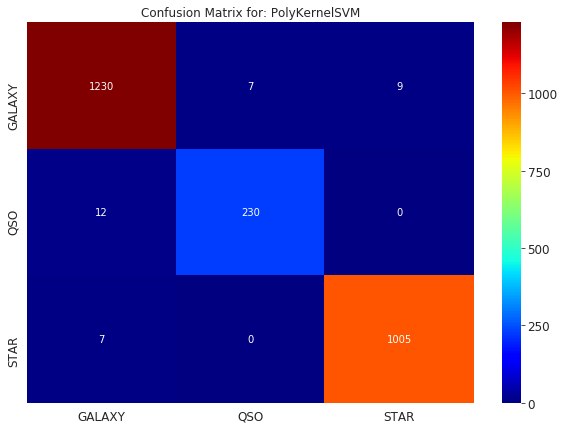

In [13]:
poly_svm_clf = SVC(kernel="poly", gamma="scale", degree=3, coef0=100, C=5)
do_stuff(poly_svm_clf, "PolyKernelSVM", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Decision Tree

DecisionTree
[0.98600933 0.98600933 0.98866667 0.98198799 0.98732488]
Accuracy: 0.986 (+/- 0.004)
DecisionTree :
 [[1220   19    7]
 [  16  226    0]
 [   4    0 1008]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.92      0.93      0.93       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500





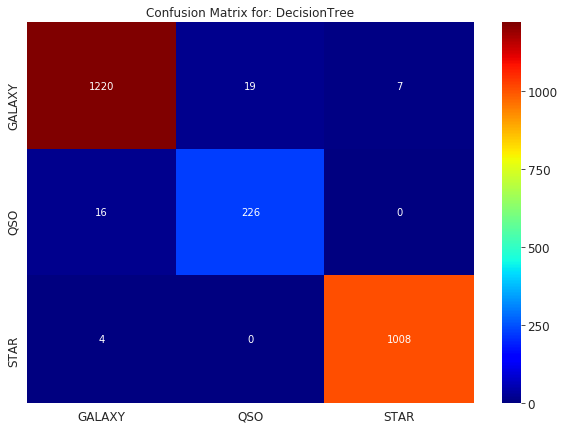

In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
do_stuff(tree_clf, "DecisionTree", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Random Forest

RandomForest
[0.9853431  0.9853431  0.99133333 0.98799199 0.98999333]
Accuracy: 0.988 (+/- 0.005)
RandomForest :
 [[1232    4   10]
 [  14  228    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





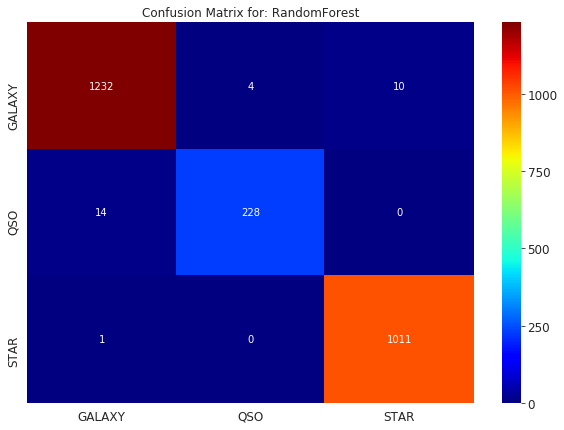

In [15]:
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
do_stuff(rnd_clf, "RandomForest", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Logistic Regression

LogisticRegression
[0.9673551  0.96535643 0.97533333 0.9766511  0.9706471 ]
Accuracy: 0.971 (+/- 0.009)
LogisticRegression :
 [[1171    4   71]
 [  18  224    0]
 [  13    0  999]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.94      0.96      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.93      0.99      0.96      1012

   micro avg       0.96      0.96      0.96      2500
   macro avg       0.96      0.95      0.96      2500
weighted avg       0.96      0.96      0.96      2500





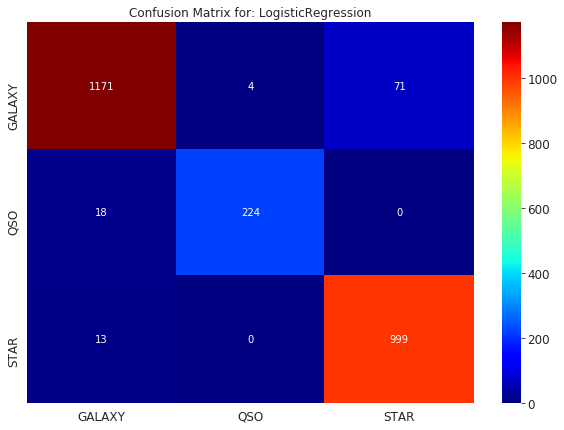

In [16]:
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
do_stuff(log_clf, "LogisticRegression", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Gradient Boosting

XGB
[0.98867422 0.98401066 0.99133333 0.98865911 0.99332889]
Accuracy: 0.989 (+/- 0.006)
XGB :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





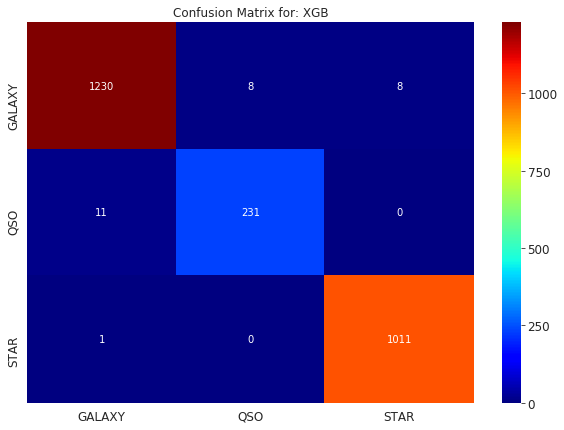

In [17]:
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=42)
do_stuff(xgb_clf, "XGB", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Bagging Classifier (DecisionTreeClassifier)

BaggingCLF(DecisionTreeClassifier)
[0.98201199 0.9793471  0.986      0.98599066 0.98799199]
Accuracy: 0.984 (+/- 0.006)
BaggingCLF(DecisionTreeClassifier) :
 [[1232    4   10]
 [  13  229    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





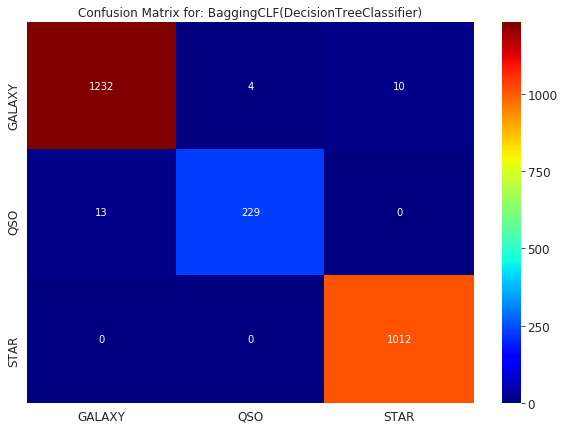

In [18]:
bag_df_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
do_stuff(bag_df_clf, "BaggingCLF(DecisionTreeClassifier)", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Ada Boost

AdaBoost(DecisionTreeClassifier)
[0.67954697 0.93404397 0.66266667 0.82054703 0.74116077]
Accuracy: 0.768 (+/- 0.200)
AdaBoost(DecisionTreeClassifier) :
 [[1223   16    7]
 [ 125  117    0]
 [ 151    0  861]]
              precision    recall  f1-score   support

      GALAXY       0.82      0.98      0.89      1246
         QSO       0.88      0.48      0.62       242
        STAR       0.99      0.85      0.92      1012

   micro avg       0.88      0.88      0.88      2500
   macro avg       0.90      0.77      0.81      2500
weighted avg       0.89      0.88      0.88      2500





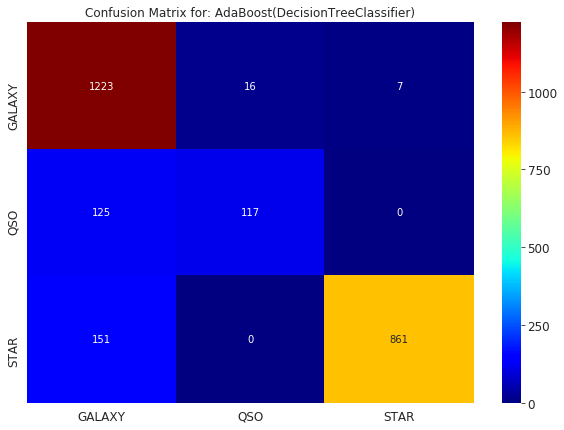

In [19]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
do_stuff(ada_clf, "AdaBoost(DecisionTreeClassifier)", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## SGD

SGDClassifier
[0.96868754 0.96802132 0.97466667 0.9766511  0.97131421]
Accuracy: 0.972 (+/- 0.007)
SGDClassifier :
 [[1213    7   26]
 [  29  213    0]
 [  12    0 1000]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      1246
         QSO       0.97      0.88      0.92       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.95      0.96      2500
weighted avg       0.97      0.97      0.97      2500





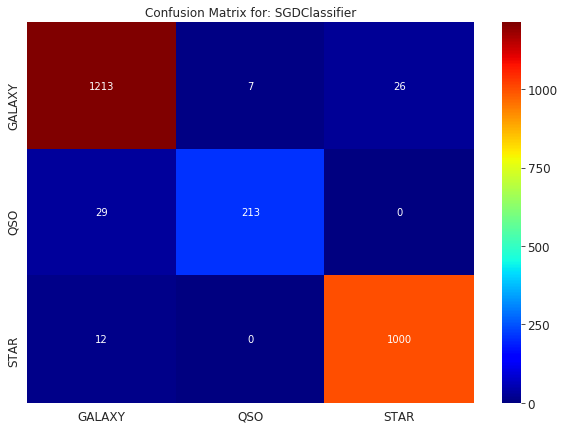

In [20]:
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
do_stuff(sgd_clf, "SGDClassifier", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## MLP

MLP
[0.98800799 0.98267821 0.99133333 0.99199466 0.98999333]
Accuracy: 0.989 (+/- 0.007)
MLP :
 [[1221    3   22]
 [  10  232    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.99      0.96      0.97       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





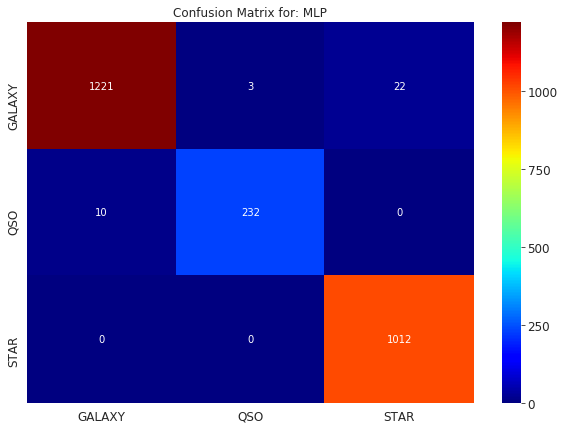

In [21]:
mlp_clf = MLPClassifier(random_state=42, max_iter=2000)
do_stuff(mlp_clf, "MLP", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Extra Trees

XTrees
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
XTrees :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500





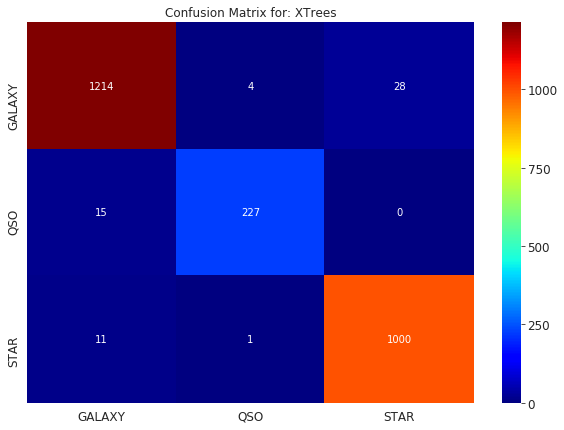

In [22]:
xtree_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
do_stuff(xtree_clf, "XTrees", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Passive Aggressive Classifier

PassiveAggressiveClassifier
[0.97001999 0.96069287 0.91466667 0.97598399 0.97531688]
Accuracy: 0.959 (+/- 0.046)
PassiveAggressiveClassifier :
 [[1213   13   20]
 [  68  174    0]
 [  43    1  968]]
              precision    recall  f1-score   support

      GALAXY       0.92      0.97      0.94      1246
         QSO       0.93      0.72      0.81       242
        STAR       0.98      0.96      0.97      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.94      0.88      0.91      2500
weighted avg       0.94      0.94      0.94      2500





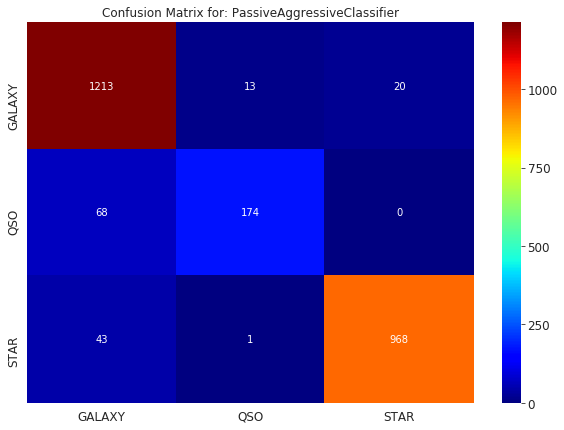

In [23]:
pa_clf = PassiveAggressiveClassifier(max_iter=5000, random_state=0, tol=1e-3)
do_stuff(pa_clf, "PassiveAggressiveClassifier", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Ridge Classifier

RidgeClassifier
[0.92071952 0.90672885 0.93266667 0.92261508 0.91661107]
Accuracy: 0.920 (+/- 0.017)
RidgeClassifier :
 [[1112    0  134]
 [  36  188   18]
 [  87    1  924]]
              precision    recall  f1-score   support

      GALAXY       0.90      0.89      0.90      1246
         QSO       0.99      0.78      0.87       242
        STAR       0.86      0.91      0.89      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.92      0.86      0.88      2500
weighted avg       0.89      0.89      0.89      2500





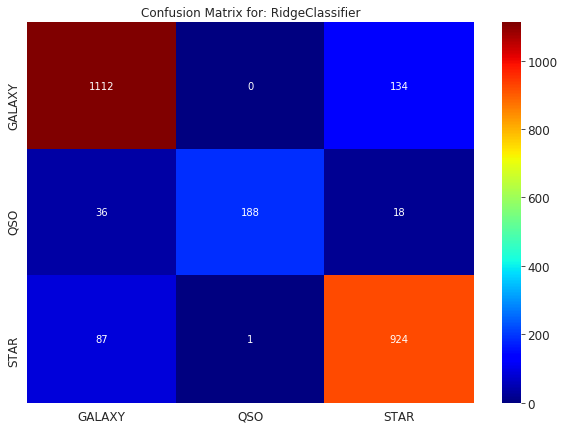

In [24]:
r_clf = RidgeClassifier()
do_stuff(r_clf, "RidgeClassifier", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Naive Bayes

NaiveBayes
[0.98001332 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.008)
NaiveBayes :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500





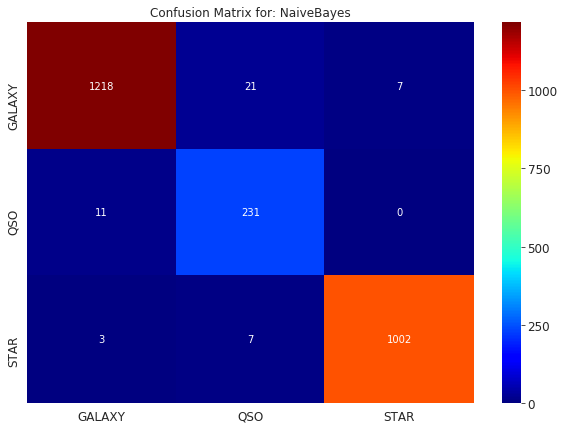

In [25]:
nb_clf = GaussianNB()
do_stuff(nb_clf, "NaiveBayes", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Multinomial Naive Bayes

MultinomialNaiveBayes
[0.92071952 0.90672885 0.93266667 0.92261508 0.91661107]
Accuracy: 0.920 (+/- 0.017)
MultinomialNaiveBayes :
 [[1112    0  134]
 [  36  188   18]
 [  87    1  924]]
              precision    recall  f1-score   support

      GALAXY       0.90      0.89      0.90      1246
         QSO       0.99      0.78      0.87       242
        STAR       0.86      0.91      0.89      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.92      0.86      0.88      2500
weighted avg       0.89      0.89      0.89      2500





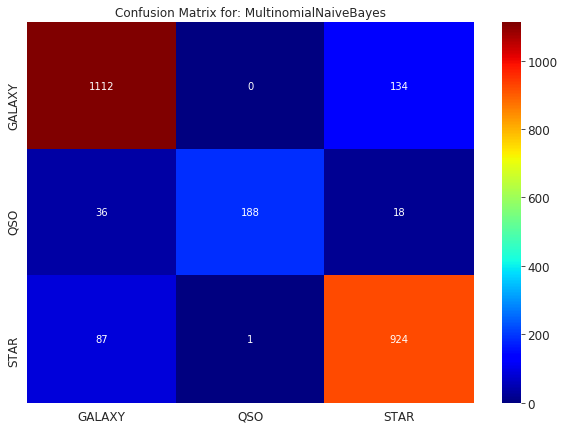

In [26]:
mnb_clf = MultinomialNB()
do_stuff(r_clf, "MultinomialNaiveBayes", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## LDA

LDA
[0.93537642 0.91672219 0.946      0.9299533  0.92328219]
Accuracy: 0.930 (+/- 0.020)
LDA :
 [[1131    0  115]
 [  45  185   12]
 [  74    2  936]]
              precision    recall  f1-score   support

      GALAXY       0.90      0.91      0.91      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.88      0.92      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.90      0.90      0.90      2500





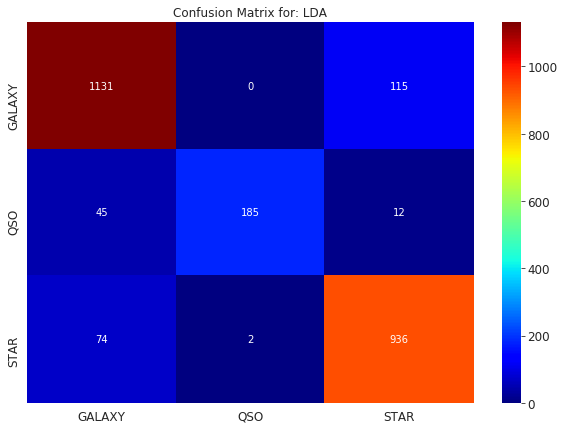

In [27]:
lda_clf = LinearDiscriminantAnalysis()
do_stuff(lda_clf, "LDA", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## QDA

QDA
[0.9793471  0.98134577 0.98666667 0.98865911 0.98732488]
Accuracy: 0.985 (+/- 0.007)
QDA :
 [[1225   15    6]
 [   5  237    0]
 [   9    2 1001]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.93      0.98      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





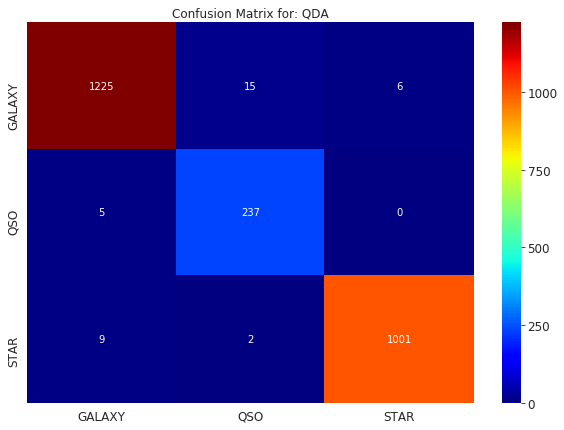

In [28]:
qda_clf = QuadraticDiscriminantAnalysis()
do_stuff(qda_clf, "QDA", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

## Voting Classifier

VotingClassifier
[0.98600933 0.98401066 0.99066667 0.98932622 0.99132755]
Accuracy: 0.988 (+/- 0.006)
VotingClassifier :
 [[1233    4    9]
 [  13  229    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500





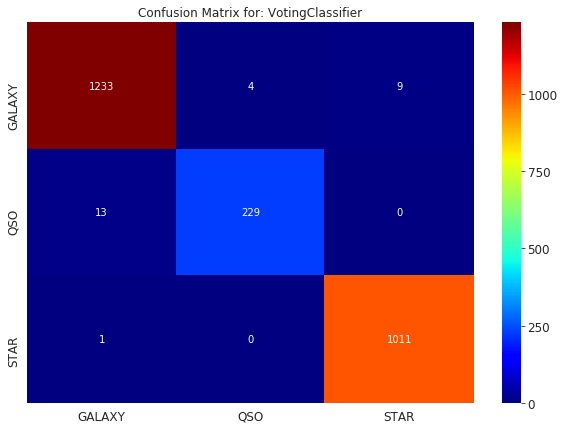

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    v_clf = VotingClassifier(estimators=[
        ("SVC", svm_clf),
        ("NuSVC", nusvm_clf),
        ("RbfSVC", rbf_svm_clf),
        ("PolySVC", poly_svm_clf),
        ("Tree", tree_clf),
        ("RF", rnd_clf),
        ("XGB", xgb_clf),
        ("Bagging", bag_df_clf),
        ("MLP", mlp_clf),
        ("XTrees", xtree_clf),
        ("NaiveBayes", nb_clf),
        ("QDA", qda_clf),
    ], voting="hard", n_jobs=-1)
    do_stuff(v_clf, "VotingClassifier", class_names, X_train_rob_scaled, y_train, X_test_rob_scaled, y_test, result_sets)

# Results

## Ordered results

In [31]:
order_results(result_sets)

By Acc:
PolyKernelSVM 0.9910664854517715
XGB 0.9892012404153661
MLP 0.9888015069043735
VotingClassifier 0.9882680845043337
RandomForest 0.9880009732152473
RbfKernelSVM 0.9865335062519287
DecisionTree 0.9859996392294693
QDA 0.9846687054823876
BaggingCLF(DecisionTreeClassifier) 0.9842683498081554
NuSVC 0.9841356386380615
SVC 0.9816020376305353
XTrees 0.9809344818375475
NaiveBayes 0.9786674589040558
LinearSVC 0.9738686122675315
SGDClassifier 0.971868167526593
LogisticRegression 0.9710686115564199
KNN 0.9656014986080734
PassiveAggressiveClassifier 0.9593360784012201
LDA 0.9302668182519191
RidgeClassifier 0.919868237037735
MultinomialNaiveBayes 0.919868237037735
AdaBoost(DecisionTreeClassifier) 0.7675930822487772


By Precision(avg=micro):
BaggingCLF(DecisionTreeClassifier) 0.9892
VotingClassifier 0.9892
XGB 0.9888
RandomForest 0.9884
PolyKernelSVM 0.986
MLP 0.986
QDA 0.9852
NuSVC 0.9832
RbfKernelSVM 0.9828
DecisionTree 0.9816
NaiveBayes 0.9804
XTrees 0.9764
SVC 0.9736
LinearSVC 0.9716
SGDC

## ROC AUC scores

In [32]:
print_roc_auc_scores(result_sets, y_test)

KNN
{'GALAXY': 0.9367123119340741, 'QSO': 0.9637688585671514, 'STAR': 0.9498756853244933}


SVC
{'GALAXY': 0.9743587774338808, 'QSO': 0.9658349742696308, 'STAR': 0.9838908899655744}


LinearSVC
{'GALAXY': 0.9720099533819226, 'QSO': 0.9424433968479383, 'STAR': 0.985512558969782}


NuSVC
{'GALAXY': 0.9839895960534636, 'QSO': 0.9660564091677708, 'STAR': 0.9916193845892304}


RbfKernelSVM
{'GALAXY': 0.9831947079138091, 'QSO': 0.9679010899721101, 'STAR': 0.991145235666624}


PolyKernelSVM
{'GALAXY': 0.986003696677854, 'QSO': 0.9736565672832684, 'STAR': 0.9935173084278975}


DecisionTree
{'GALAXY': 0.9815921315034266, 'QSO': 0.9627348856956716, 'STAR': 0.9956715648773853}


RandomForest
{'GALAXY': 0.9884011612278909, 'QSO': 0.9701886405727295, 'STAR': 0.9961457137999914}


LogisticRegression
{'GALAXY': 0.9575432452428313, 'QSO': 0.9619241777628121, 'STAR': 0.9697195482170937}


XGB
{'GALAXY': 0.9887947652583963, 'QSO': 0.9755012480876077, 'STAR': 0.9968177568107441}


BaggingCLF(DecisionTree